# 1. Data prepration
    
## 1.1 Load data and preprocessing
In this part we import libraries and data set. Data set has 9 columns and 2075259 samples. It also has missing values. The first step is to load data set and handle missing values. Also the first two columns contain time and date, which we eliminate in our first version of code.  

In [1]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("data/household_power_consumption.txt",";")

print("The size of data set is:",data.shape)
#print("The first three rows of data set:\n",data.head(3))
#print("The last three rows of data set:\n",data.tail(3))

X = pd.DataFrame(data.iloc[:,2:6], columns=["Global_active_power","Global_reactive_power","Voltage","Global_intensity"])
Y = pd.DataFrame(data.iloc[:,7], columns=["Sub_metering_2"])

X = X.replace({'?':0})
Y = Y.replace({'?':0})

The size of data set is: (2075259, 9)


## 1.2 Train and test sets
Befor starting the training we need to split our data to train and test. In traditional learning algorithms, people usually use 70%/30% train/test or 60%/20%/20% train/dev/test set. Nowadays, because of having large data sets, people usually use 98%/1%/1% train/dev/test set. In this assignment we used the traditional way of spliting data into train and test with the ratio of 70%/30% of train/test. 

In [4]:
X_features = X.columns
Y_features = Y.columns
XY = pd.concat([X[X_features], Y[Y_features]], axis=1)

# Split XY into training set and test set of equal size
train, test = train_test_split(XY, test_size = 0.30)
# Sort the train and test sets after index (which became unsorted through sampling)
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)

# Extract X,Y components from test and train sets
X_train = train[X_features].astype(float); X_test = test[X_features].astype(float)
Y_train = train[Y_features].astype(float); Y_test = test[Y_features].astype(float)

print("Size of train set (X): ",X_train.shape)
print("Size of train set (Y): ",Y_train.shape)
print("Size of test set (X): ",X_test.shape)
print("Size of test set (Y): ",Y_test.shape)

Size of train set (X):  (1452681, 4)
Size of train set (Y):  (1452681, 1)
Size of test set (X):  (622578, 4)
Size of test set (Y):  (622578, 1)


# 2. Logistic ridge regression with different optimizers

The goal of this part is to implement logistic ridge regression with four different optimizers (GD, SGD, SAG, SVRG). We define logistic ridge as following:  

\begin{equation*}
f(w) = \frac{1}{N} \sum_{i\in[N]} f_i(w) + \lambda ||w||_2^2
\end{equation*}

where 

\begin{equation*}
f_i(w) = \log(1+\exp(y_iw^Tx_i))
\end{equation*}

In the following section we each of optimizers and will try to optimize the specified goal function.

In [5]:
def function_gradient_GD(X, Y, w, lambda_):
    Z = np.matmul(X,np.diagflat(Y))
    D,N = Z.shape
    Z_ = -1 * np.matmul(w.T , Z)
    A = 1/(1+np.exp(Z_))
    A_ = np.diagflat(A-1)
    G = 1 / N * np.sum(np.matmul(Z , A_), axis=1,keepdims=True) + 2 * lambda_ * w
    return G

In [6]:
X = np.array([[2,3,3],[1,4,3]])
Y = np.array([[1],[2],[5]])
w = np.array([[0.01],[0.21]])

print(function_gradient_GD(X,Y,w,0.1))

[[-0.76964991]
 [-0.68160782]]


In [7]:
def solver(x,y, w, alpha = 0.1, num_iters = 1000, lambda_ = 0.1, epsilon = 0.0001, optimizer = "GD",mem=False):
    if (optimizer == "GD") :
        for i in range(num_iters):
            g = function_gradient_GD(x, y, w, lambda_)
            w = w - alpha * g
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            if (np.linalg.norm(g) <= epsilon):
                break
                
    elif (optimizer == "SGD"):
        for i in range(num_iters):
            D,N = x.shape
            sample_no = int(np.random.random(1) * N)
            Z = np.matmul(x,np.diagflat(y))
            A = -1 * np.matmul(w.T, Z[:,i])
            G = (Z[:,[i]]*float(1/(1+np.exp(A))-1))+ 2 * lambda_ * w
            w = w - alpha * G
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SGD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                
    elif (optimizer == "SVRG"):
        T = 100
        K = math.floor(num_iters/T)
        Z = np.matmul(x,np.diagflat(y))
        N = x.shape[1]
        for k in range(K):
            wz = np.matmul(w.T , Z)
            diag = np.diagflat(1/(1+np.exp(-1*wz))-np.ones((1,N)))
            Ga_ = np.matmul(Z , diag)
            ga_ = (1/N) * np.matmul(Ga_ , np.ones((N,1)))
            for t in range(T):
                r = int(np.random.random(1) * N)
                col = Z[:,[r]]
                #col = col.reshape((col.shape[0],1))
                g = np.matmul(col , (1/(1+np.exp(-1 * np.matmul(w.T , col)))-1))
                Ga_col = Ga_[:,r]
                Ga_col = Ga_col.reshape(Ga_col.shape[0],1)
                w = w - alpha * (g - Ga_col + ga_ + 2 * lambda_ * w)
            if (k%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SVRG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            
    elif (optimizer == "SAG"):
        Z = np.matmul(x,np.diagflat(y))
        d = x.shape[0]
        N = x.shape[1]
        G = np.zeros((d,N))

        for k in range(num_iters):
            r = int(np.random.random(1) * N)
            col = Z[:,r].reshape(Z[:,r].shape[0],1)
            B = np.matmul(col ,(1/(1 + np.exp(-1 * np.matmul(w.T,col))) - 1))
            B = B.reshape(B.shape[0])
            G[:,r] = B
            g = (1/N) * np.matmul(G , np.ones((N,1)))  + 2 * lambda_ * w
            w = w - alpha * g
            if (k%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SAG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            
            
    return w

In [8]:
def cost(x,y,w,lambda_ = 0.01):
    D, N = x.shape
    value = 0
    for i in range(N):
        Z = -1 * y[i] * np.matmul(w.T , (x[:,i]).reshape(D,1))
        value += np.log(1+np.exp(Z))
    norm = np.linalg.norm(w)
    c = lambda_ * norm ** 2
    return value/N + c

In [9]:
X = np.array([[2,3,5],[1,4,4]])
Y = np.array([[1],[2],[7]])
w = np.array([[0.01],[0.21]])

print(cost(X,Y,w,0.1))

[[0.25389454]]


In [10]:
y = np.array(Y_train.iloc[0:6000])
x = np.array(X_train.iloc[0:6000,:])

N,D = x.shape
w = np.random.rand(D,1)*0.01

##################GD###################
start = time.time()
gde = solver(x.T,y,w,num_iters=100)
end = time.time()
#print("Weights of GD after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of GD after convergence: ",err)

print("Training time for GD: ", end-start)

##################SGD###################
start = time.time()
gde = solver(x.T,y,w, num_iters=500,optimizer = "SGD")
end = time.time()
#print("Weights of SGD after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SGD after convergence: ",err)
print("Training time for SGD: ", end-start)

##################SVRG###################
start = time.time()
gde = solver(x.T,y,w, num_iters=1000,optimizer = "SVRG")
end = time.time()
#print("Weights of SVRG after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SVRG after convergence: ",err)
print("Training time for SVRG: ", end-start)

##################SAG###################
start = time.time()
gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG")
end = time.time()
#print("Weights of SAG after convergence: \n",gde)

err = cost(x.T,y,gde)
print("Cost of SAG after convergence: ",err)
print("Training time for SAG: ", end-start)

Cost of GD after convergence:  [[0.47308965]]
Training time for GD:  19.46517848968506
Cost of SGD after convergence:  [[0.4720629]]
Training time for SGD:  59.79012608528137


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Cost of SVRG after convergence:  [[0.4736985]]
Training time for SVRG:  1.3797192573547363
Cost of SAG after convergence:  [[0.47213927]]
Training time for SAG:  0.10671424865722656


In [11]:
ti= np.zeros((50,4))
cost_= np.zeros((50,4))
for i in range(50):
    print("......",i,".......")
    ##################GD###################
    start = time.time()
    gde = solver(x.T,y,w,num_iters=i)
    end = time.time()

    cost_[i,0] = cost(x.T,y,gde)

    ti[i,0] = end-start

    ##################SGD###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SGD")
    end = time.time()

    cost_[i,1] = cost(x.T,y,gde)
    
    ti[i,1] = end-start
    ##################SVRG###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SVRG")
    end = time.time()

    cost_[i,2] = cost(x.T,y,gde)
    
    ti[i,2] = end-start
    ##################SAG###################
    start = time.time()
    gde = solver(x.T,y,w, num_iters=i,optimizer = "SAG")
    end = time.time()

    cost_[i,3] = cost(x.T,y,gde)
    ti[i,3] = end-start
    print("GD","cost:",cost_[i,0],"time:",ti[i,0])
    print("SGD","cost:",cost_[i,1],"time:",ti[i,1])
    print("SVRG","cost:",cost_[i,2],"time:",ti[i,2])
    print("SAG","cost:",cost_[i,3],"time:",ti[i,3])

...... 0 .......
GD cost: 0.5676323159414753 time: 0.0
SGD cost: 0.5676323159414753 time: 0.0
SVRG cost: 0.5676323159414753 time: 0.11819791793823242
SAG cost: 0.5676323159414753 time: 0.10671305656433105
...... 1 .......
GD cost: 0.529719653191031 time: 0.18650221824645996
SGD cost: 1.1575403163684326 time: 0.11271333694458008
SVRG cost: 0.5676323159414753 time: 0.10671496391296387
SAG cost: 0.5688220057796808 time: 0.08926868438720703
...... 2 .......
GD cost: 0.5274352708311351 time: 0.41048669815063477
SGD cost: 1.1303942357467116 time: 0.19448566436767578
SVRG cost: 0.5676323159414753 time: 0.0967411994934082
SAG cost: 0.5700031013350216 time: 0.08579087257385254
...... 3 .......
GD cost: 0.525241350012691 time: 0.6366636753082275
SGD cost: 1.1043231399176108 time: 0.26732516288757324
SVRG cost: 0.5676323159414753 time: 0.11430549621582031
SAG cost: 0.5711753857901813 time: 0.1062459945678711
...... 4 .......
GD cost: 0.5231343084586573 time: 0.7612171173095703
SGD cost: 1.0792844

GD cost: 0.48663638711769747 time: 8.625807046890259
SGD cost: 0.6455674370440447 time: 4.3729658126831055
SVRG cost: 0.5676323159414753 time: 0.12222552299499512
SAG cost: 0.4720633071114412 time: 0.13626551628112793
...... 36 .......
GD cost: 0.4860581020943055 time: 8.587067365646362
SGD cost: 0.6386954824435694 time: 4.533056974411011
SVRG cost: 0.5676323159414753 time: 0.12765860557556152
SAG cost: 0.4720588836513073 time: 0.13121485710144043
...... 37 .......
GD cost: 0.4855027171578399 time: 8.92971420288086
SGD cost: 0.632095657245273 time: 4.353710174560547
SVRG cost: 0.5676323159414753 time: 0.12582015991210938
SAG cost: 0.47206051596421567 time: 0.12613749504089355
...... 38 .......
GD cost: 0.48496932546485827 time: 8.913966655731201
SGD cost: 0.625757185124829 time: 4.549869537353516
SVRG cost: 0.5676323159414753 time: 0.1097114086151123
SAG cost: 0.4721194870658039 time: 0.14261341094970703
...... 39 .......
GD cost: 0.4844570560829188 time: 10.599048137664795
SGD cost: 0

[0.56763232 1.15754032 1.13039424 1.10432314 1.07928446 1.05523731
 1.03214243 1.0099621  0.98866012 0.9682017  0.94855343 0.92968323
 0.91156029 0.89415501 0.87743899 0.86138492 0.8459666  0.83115884
 0.81693746 0.80327925 0.79016191 0.77756402 0.765465   0.7538451
 0.74268535 0.73196752 0.72167413 0.71178835 0.70229404 0.69317572
 0.68441847 0.67600802 0.66793062 0.66017308 0.65272274 0.64556744
 0.63869548 0.63209566 0.62575719 0.61966972 0.61382331 0.60820842
 0.60281589 0.59763689 0.59266299 0.58788605 0.58329828 0.57889218
 0.57466057 0.57059653]


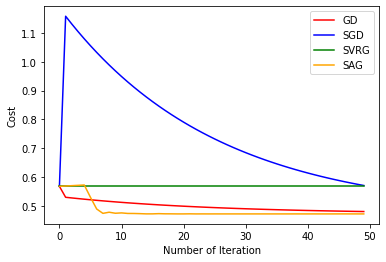

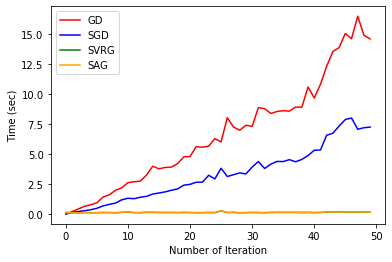

In [12]:
import matplotlib.pyplot as plt

print(cost_[:,1])
l0 = plt.plot(cost_[:,0],color="red")
l1 = plt.plot(cost_[:,1],color="blue")
l2 = plt.plot(cost_[:,2],color="green")
l3 = plt.plot(cost_[:,3],color="orange")
plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="red")
l1 = plt.plot(ti[:,1],color="blue")
l2 = plt.plot(ti[:,2],color="green")
l3 = plt.plot(ti[:,3],color="orange")
plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

# 2.1 results 

As we can compare we can see that the GD is better than other algorithms in terms of accuracy but it is slower than other algorithms. GD even with just 100 of iteration take a long time to be trained (24 seconds in comparison with 10 seconds for SGD for example) and interestingly it converges just with these few numbers of iterations. Results shows that SAG is really good in comparision with others. This algorithm is as accurate as others and also it is really fast.

# 3. Tunning the lambda paramter

To tune hyper-paramter there are different methods. One methos is to define space for hyper-parameters of the model, for example here we have a space with just one dimension. Then we can define points in this space and train our model with the paramters of each point. The following image shows how we can define and search space to tune hyper-paramters. Here we consider lambda as a hyper-paramter of the model and then with different values of lambda we compute cost (error metric, it can be MSE, NMAE, or any other metric here for simplicity we used cost which was defined before) for each model. 

![title](search.png)

As the figure shows we can search the space with two different approaches.

- Grid search
- Random search

Both of these methods are very common but the Random seach in first round is better. Because in this search it is mostly probable to find a good solution. We can also use our knowledge to define the space, for example we can define a logarithmic scale for our space. We tune this hyper-paramter just for the logistic ridge regression with SAG optimizer.

In [13]:
space = [0.01,0.5, 0.1,0.5, 1,5, 10]

for la in space:
    start = time.time()
    gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG", lambda_=la)
    end = time.time()
    print("Weights of SAG after convergence: \n",gde)

    err = cost(x.T,y,gde)
    print("Cost of SAG after convergence: ",err)
    print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [[0.00918691]
 [0.00183183]
 [0.17073706]
 [0.01291055]]
Cost of SAG after convergence:  [[0.47232729]]
Training time for SAG:  0.11765432357788086
Weights of SAG after convergence: 
 [[2.12263940e-04]
 [2.51729867e-05]
 [2.49798144e-02]
 [8.85235408e-04]]
Cost of SAG after convergence:  [[0.47245494]]
Training time for SAG:  0.1107032299041748
Weights of SAG after convergence: 
 [[0.00121145]
 [0.0003089 ]
 [0.13156451]
 [0.00089355]]
Cost of SAG after convergence:  [[0.47220635]]
Training time for SAG:  0.10272431373596191
Weights of SAG after convergence: 
 [[2.18034664e-04]
 [1.66834116e-05]
 [2.28372744e-02]
 [9.14015790e-04]]
Cost of SAG after convergence:  [[0.47273374]]
Training time for SAG:  0.10970497131347656
Weights of SAG after convergence: 
 [[1.95316170e-04]
 [1.53898904e-05]
 [2.26930145e-02]
 [8.24188389e-04]]
Cost of SAG after convergence:  [[0.4727587]]
Training time for SAG:  0.11151957511901855
Weights of SAG after convergence: 

In [14]:
space = [0.070, 0.075,0.080, 0.085, 0.090, 0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130]

for la in space:
    start = time.time()
    gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG", lambda_=la)
    end = time.time()
    print("Weights of SAG after convergence: \n",gde)

    err = cost(x.T,y,gde)
    print("Cost of SAG after convergence: ",err)
    print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [[0.00267121]
 [0.00056223]
 [0.11606739]
 [0.00347602]]
Cost of SAG after convergence:  [[0.47216814]]
Training time for SAG:  0.10571599006652832
Weights of SAG after convergence: 
 [[0.00282424]
 [0.00056389]
 [0.11687741]
 [0.00491574]]
Cost of SAG after convergence:  [[0.47217016]]
Training time for SAG:  0.1047215461730957
Weights of SAG after convergence: 
 [[0.00180614]
 [0.00050143]
 [0.10773272]
 [0.00136401]]
Cost of SAG after convergence:  [[0.47214935]]
Training time for SAG:  0.10372185707092285
Weights of SAG after convergence: 
 [[0.00188138]
 [0.00044648]
 [0.11680987]
 [0.00224542]]
Cost of SAG after convergence:  [[0.47216976]]
Training time for SAG:  0.10172700881958008
Weights of SAG after convergence: 
 [[0.0020182 ]
 [0.00030221]
 [0.12252134]
 [0.00323441]]
Cost of SAG after convergence:  [[0.47218349]]
Training time for SAG:  0.11668753623962402
Weights of SAG after convergence: 
 [[0.0016872 ]
 [0.00029634]
 [0.15135025]
 [0

# 3.1 Results

In the first round the best lambda is 0.1 and values close to it. Now we can zoom in the space around 0.1 and search the vecinity of 0.1. In the second round we see that 0.125, 0.130 give the best results. We can continue our search around these values. For this assignment we just continue two rounds.

# 4. Comparing different optimizers

We mostly compared different in previous part. In this part we mostly focus on the memory usage and other system metrics that our python code uses during the run.

In [188]:
import resource
#print(usage[0],usage[1], (usage[2]*resource.getpagesize())/1000000.0 )
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)

y = np.array(Y_train.iloc[0:6000])
x = np.array(X_train.iloc[0:6000,:])

N,D = x.shape
w = np.random.rand(D,1)*0.01

##################GD###################
gde = solver(x.T,y,w,num_iters=100,mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)

##################SGD###################
gde = solver(x.T,y,w, num_iters=500,optimizer = "SGD",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)
##################SVRG###################
gde = solver(x.T,y,w, num_iters=1000,optimizer = "SVRG",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)
##################SAG###################
gde = solver(x.T,y,w, num_iters=100,optimizer = "SAG",mem=True)
usage=resource.getrusage(resource.RUSAGE_SELF)
print("mem (mb):", (usage[2]*resource.getpagesize())/1000000.0)


mem (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem for GD (mb): 7211.515904
mem (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem for SGD (mb): 7211.515904
mem fo